In [ ]:
import ee
import geemap
import logging
import multiprocessing
import os
import torch
import pandas as pd
from skimage.measure.entropy import shannon_entropy
import numpy as np
import re
import rasterio
import matplotlib.pyplot as plt
import json
from utils.functions import getResult, getRequests, get_files_info
from sklearn.mixture import GaussianMixture
from numpy.linalg import norm

GEE_PROJECT_ID = "fusion-371234"
ee.Authenticate()
ee.Initialize(project=GEE_PROJECT_ID)

# Functions

In [26]:
def compute_ndvi(img, red_idx=3, nir_idx=7):
    red = img[red_idx]
    nir = img[nir_idx]
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def get_s2_image(start, end):
    return (
        ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
        .filterDate(start, end)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 100))
        .sort('CLOUDY_PIXEL_PERCENTAGE')
        .first()
    )

In [ ]:
scale = 3000
sample_point = "0"
# OUTDIR = "s2_ejura_2017_2018"
OUTDIR = "s2_ejura_2017_2020"

n_files, name_files = get_files_info(OUTDIR)
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

file_paths = []
dates = []
for f in matching_files:
    file_paths.append(os.path.join(OUTDIR, f))
    match = re.search(r"_(\d{8})T", f)
    if match:
        date_str = match.group(1)
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

n_image = 1
with rasterio.open(file_paths[n_image]) as src:
    img = src.read() / scale
img_rgb = np.clip(img[[3, 2, 1]].transpose(1, 2, 0), 0, 1)

fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(24, 10),
    gridspec_kw={'width_ratios': [1, 1]}
)
fig.subplots_adjust(right=0.8)
plt.rcParams['toolbar'] = 'toolmanager'

ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')})", fontsize=14)
ax_img.axis("off")

def plot_ndvi_time_series(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"NDVI Time-Series — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Date")
    ax_spec.set_ylabel("NDVI")
    ax_spec.grid(True, linestyle="--")
    
    ndvi_values = []
    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            img = src.read() / scale
        nir = img[7, y, x]   # banda 8 (NIR)
        red = img[3, y, x]   # banda 4 (RED)
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_values.append(ndvi)
    
    valid_pairs = sorted(
        [(d, n) for d, n in zip(dates, ndvi_values) if d is not None],
        key=lambda x: x[0]
    )
    sorted_dates, sorted_ndvi = zip(*valid_pairs)
    
    # Plot da série temporal
    ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", label="NDVI", markersize=6)
    
    # Destacar o ponto n_image
    if dates[n_image] is not None:
        highlight_date = dates[n_image]
        highlight_ndvi = ndvi_values[n_image]
        ax_spec.plot(highlight_date, highlight_ndvi, "o", color="red", 
                    markersize=12, markeredgewidth=2, markeredgecolor='darkred',
                    label=f"Current Image ({highlight_date.strftime('%Y-%d-%m')})", zorder=5)
    
    # Formatar eixo X para mostrar apenas Ano-Mês
    ax_spec.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_spec.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax_spec.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Destacar pixel clicado na imagem RGB
    ax_img.clear()
    ax_img.imshow(img_rgb)
    ax_img.plot(x, y, 'r+', markersize=15, markeredgewidth=2)
    ax_img.plot(x, y, 'ro', markersize=20, markerfacecolor='none', 
               markeredgewidth=2, markeredgecolor='red')
    ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')}) - Pixel ({x}, {y})", fontsize=14)
    ax_img.axis("off")
    
    fig.canvas.draw_idle()

def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()

# Study Area

In [27]:
Map = geemap.Map(center=[7.375, -1.3667], zoom=20)
Map.add_basemap("HYBRID")

before_date = ('2017-04-01', '2017-04-09')
after_date  = ('2017-09-01', '2017-09-07')

img_before = get_s2_image(*before_date)
img_after  = get_s2_image(*after_date)

ndvi_before = img_before.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_after  = img_after.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_diff   = ndvi_after.subtract(ndvi_before).rename('NDVI_diff')

rgb_vis = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000,
    'gamma': 1.2
}

ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['brown', 'yellow', 'green']
}

diff_vis = {
    'min': -0.4,
    'max': 0.2,
    'palette': ['red', 'white', 'blue']
}

Map.addLayer(img_before, rgb_vis, 'Sentinel-2 RGB (Before infestation)')
Map.addLayer(img_after,  rgb_vis, 'Sentinel-2 RGB (After infestation)')

Map.addLayer(ndvi_before, ndvi_vis, 'NDVI (Before infestation)')
Map.addLayer(ndvi_after,  ndvi_vis, 'NDVI (After infestation)')
Map.addLayer(ndvi_diff,   diff_vis, 'NDVI Difference (FAW impact)')

Map

Map(center=[7.375, -1.3667], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [ ]:
# Convert to GeoJSON format
geojson_dict = Map.user_roi.getInfo()
roi_name = "ghana_pest"

# Save to file
with open(f"rois/{roi_name}.json", "w") as f:
    json.dump(geojson_dict, f)

print(f"✅ Region saved as {roi_name}.json")

# Before and After Pest Attack

In [18]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"
selected_bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
CLOUD_FILTER = 100
crs = "EPSG:4326"
scale = 10 

before_date = ('2017-04-01', '2017-04-9')
after_date  = ('2017-09-01', '2017-09-07')

DATE = before_date  # change to before_date if needed

roi_name = "rois/ghana_pest"
with open(f"{roi_name}.json", "r") as f:
    region_data = json.load(f)

region = ee.Geometry(region_data)

collection = (
    ee.ImageCollection(S2_SR_COLLECTION_ID)
    .filterDate(DATE[0], DATE[1])
    .filterBounds(region)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
    .select(selected_bands)
)

image = collection.median().clip(region)
path = "datasets/ghana_before_and_after"
os.makedirs(path, exist_ok=True)
geemap.ee_export_image(
    image,
    filename=f"{path}/before.tif",
    scale=scale,
    region=region,
    crs=crs,
    file_per_band=False
)

print("✅ Image downloaded exactly as the region geometry.")


Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/datasets/ghana_before_and_after/before.tif
✅ Image downloaded exactly as the region geometry.


In [22]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"
selected_bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
CLOUD_FILTER = 100
crs = "EPSG:4326"
scale = 10 

before_date = ('2017-04-01', '2017-04-07')
after_date  = ('2017-09-01', '2017-09-07')

DATE = after_date 

roi_name = "rois/ghana_pest"
with open(f"{roi_name}.json", "r") as f:
    region_data = json.load(f)

region = ee.Geometry(region_data)

collection = (
    ee.ImageCollection(S2_SR_COLLECTION_ID)
    .filterDate(DATE[0], DATE[1])
    .filterBounds(region)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
    .select(selected_bands)
)

image = collection.median().clip(region)

path = "datasets/ghana_before_and_after"
os.makedirs(path, exist_ok=True)
geemap.ee_export_image(
    image,
    filename=f"{path}/after.tif",
    scale=scale,
    region=region,
    crs=crs,
    file_per_band=False
)

print("✅ Image downloaded exactly as the region geometry.")


Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/datasets/ghana_before_and_after/after.tif
✅ Image downloaded exactly as the region geometry.


# Generate Time-Series

In [ ]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"

selected_bands = ['B1','B2','B3','B4','B5','B6', 'B7','B8','B8A','B9','B11','B12']

CLOUD_FILTER = 100
crs = "EPSG:4326"
scale = 10 

before_date = ('2018-10-26', '2018-10-27')
after_date  = ('2018-11-15', '2018-11-16')

start_date = before_date[0]
end_date   = after_date[1]

roi_name = "ghana_pest"
with open(f"rois/{roi_name}.json", "r") as f:
    region_data = json.load(f)

region = ee.Geometry(region_data)

collection = (
    ee.ImageCollection(S2_SR_COLLECTION_ID)
    .filterDate(start_date, end_date)
    .filterBounds(region)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
    .select(selected_bands)
    .sort('system:time_start')
)

print("Number of images:", collection.size().getInfo())

os.makedirs(f"{roi_name}_time_series", exist_ok=True)

image_list = collection.toList(collection.size())
n_images = collection.size().getInfo()

for i in range(n_images):
    img = ee.Image(image_list.get(i))
    
    date = ee.Date(img.get('system:time_start')).format('YYYYMMdd').getInfo()
    
    filename = f"datasets/{roi_name}_time_series/S2_{date}.tif"
    
    geemap.ee_export_image(
        img.clip(region),
        filename=filename,
        scale=scale,
        region=region,
        crs=crs,
        file_per_band=False
    )
    
    print(f"✅ Exported {filename}")

print("🎉 Time-series export completed.")


# Plots

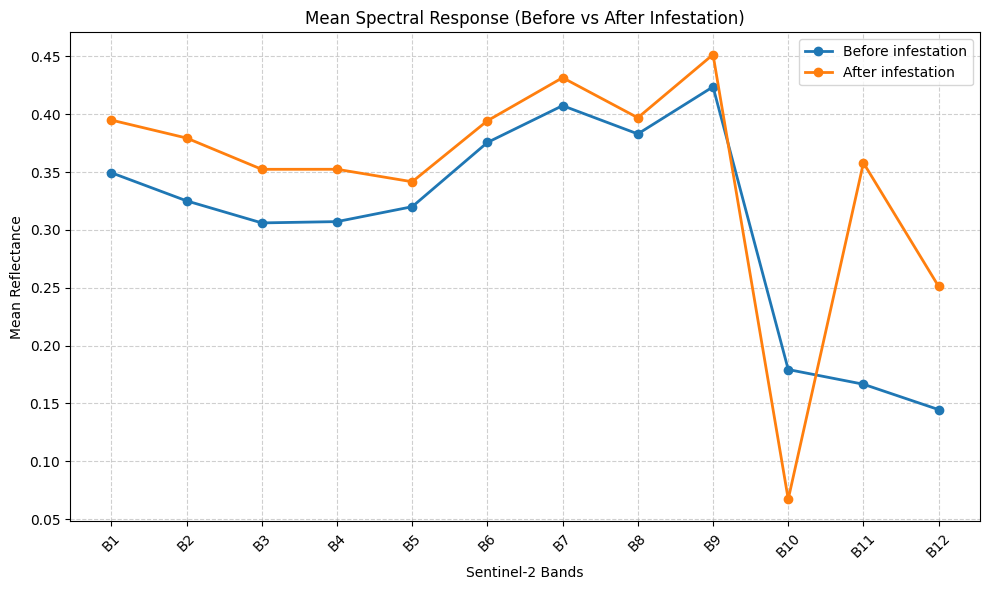

In [23]:
scale = 10000

before_path = "datasets/ghana_before_and_after/before.tif"
after_path  = "datasets/ghana_before_and_after/after.tif"

with rasterio.open(before_path) as src:
    img_before = src.read() / scale
    n_bands = img_before.shape[0]

with rasterio.open(after_path) as src:
    img_after = src.read() / scale

mean_before = np.nanmean(img_before.reshape(n_bands, -1), axis=1)
mean_after  = np.nanmean(img_after.reshape(n_bands, -1), axis=1)

bands = np.arange(1, n_bands + 1)
band_labels = [f"B{i}" for i in bands]


plt.figure(figsize=(10, 6))

plt.plot(bands, mean_before, "o-", linewidth=2, label="Before infestation")
plt.plot(bands, mean_after,  "o-", linewidth=2, label="After infestation")

plt.xticks(bands, band_labels, rotation=45)
plt.xlabel("Sentinel-2 Bands")
plt.ylabel("Mean Reflectance")
plt.title("Mean Spectral Response (Before vs After Infestation)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

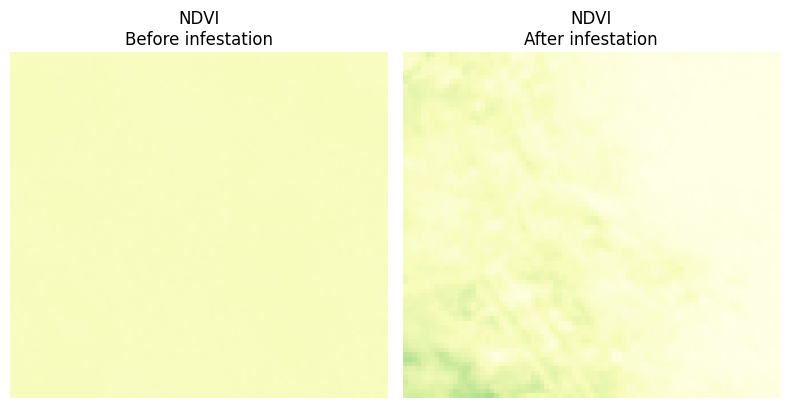

In [24]:
scale = 10000  

before_path = "datasets/ghana_before_and_after/before.tif"
after_path  = "datasets/ghana_before_and_after/after.tif"

with rasterio.open(before_path) as src:
    img_before = src.read().astype(np.float32) / scale

with rasterio.open(after_path) as src:
    img_after = src.read().astype(np.float32) / scale

ndvi_before = compute_ndvi(img_before)
ndvi_after  = compute_ndvi(img_after)

ndvi_before = np.where(np.isfinite(ndvi_before), ndvi_before, np.nan)
ndvi_after  = np.where(np.isfinite(ndvi_after), ndvi_after, np.nan)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ndvi_vmin, ndvi_vmax = 0, 1
cmap = "YlGn"

axes[0].imshow(ndvi_before, cmap=cmap, vmin=ndvi_vmin, vmax=ndvi_vmax)
axes[0].set_title("NDVI\nBefore infestation", fontsize=12)

axes[1].imshow(ndvi_after, cmap=cmap, vmin=ndvi_vmin, vmax=ndvi_vmax)
axes[1].set_title("NDVI\nAfter infestation", fontsize=12)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


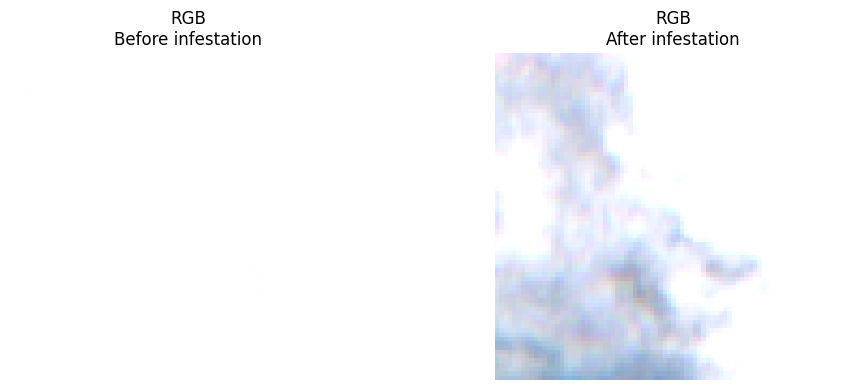

In [25]:
scale = 10000 

before_path = "datasets/ghana_before_and_after/before.tif"
after_path  = "datasets/ghana_before_and_after/after.tif"

def make_rgb(img, r=3, g=2, b=1, vmin=0, vmax=0.3):
    rgb = np.stack([img[r], img[g], img[b]], axis=-1)
    rgb = np.clip((rgb - vmin) / (vmax - vmin), 0, 1)
    return rgb


with rasterio.open(before_path) as src:
    img_before = src.read().astype(np.float32) / scale

with rasterio.open(after_path) as src:
    img_after = src.read().astype(np.float32) / scale

rgb_before = make_rgb(img_before)
rgb_after  = make_rgb(img_after)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(rgb_before)
axes[0].set_title("RGB\nBefore infestation")

axes[1].imshow(rgb_after)
axes[1].set_title("RGB\nAfter infestation")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
scale = 10000
path = "datasets/ghana_pest_time_series"

n_files, name_files = get_files_info(path)

dates = []
mean_ndvi = []

for file in sorted(name_files):
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    
    with rasterio.open(f"{path}/" + file) as src:
        red = src.read(4) / scale
        nir = src.read(8) / scale
        
        nodata = src.nodata
        
        if nodata is not None:
            mask = (red == nodata) | (nir == nodata)
            red = np.where(mask, np.nan, red)
            nir = np.where(mask, np.nan, nir)
        
        denominator = nir + red
        ndvi = np.where(denominator != 0, (nir - red) / denominator, np.nan)
        
        mean_ndvi.append(np.nanmean(ndvi))
        dates.append(pd.to_datetime(date))

plt.figure(figsize=(8, 4))
plt.plot(dates, mean_ndvi, linewidth=2)
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.title("NDVI Time Series (Mean over Region)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
scale = 10000
path = "datasets/ghana_healthy_time_series"

# Your working function
n_files, name_files = get_files_info(path)

dates = []
mean_ndvi = []

for file in sorted(name_files):
    # Extract date from filename (adapt if needed)
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    
    with rasterio.open(path + "/" + file) as src:
        # FIX: Use .read() method instead of indexing
        red = src.read(4) / scale
        nir = src.read(8) / scale
        
        nodata = src.nodata
        
        if nodata is not None:
            mask = (red == nodata) | (nir == nodata)
            red = np.where(mask, np.nan, red)
            nir = np.where(mask, np.nan, nir)
        
        denominator = nir + red
        ndvi = np.where(denominator != 0, (nir - red) / denominator, np.nan)
        
        mean_ndvi.append(np.nanmean(ndvi))
        dates.append(pd.to_datetime(date))

plt.figure(figsize=(8, 4))
plt.plot(dates, mean_ndvi, linewidth=2)
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.title("NDVI Time Series (Mean over Region)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
scale = 10000
path = "ghana_pest_time_series"

n_files, name_files = get_files_info(path)

spectral_ts = []
dates = []

for file in sorted(name_files):
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

    with rasterio.open(os.path.join(path, file)) as src:
        img = src.read().astype(np.float32) / scale
        n_bands = img.shape[0]
        mean_spectrum = np.nanmean(img.reshape(n_bands, -1), axis=1)
        spectral_ts.append(mean_spectrum)

spectral_ts = np.array(spectral_ts)  # shape: [time, bands]

bands = np.arange(1, n_bands + 1)
band_labels = [f"B{i}" for i in bands]

plt.figure(figsize=(12, 6))

for i, date in enumerate(dates):
    plt.plot(
        bands,
        spectral_ts[i],
        marker="o",
        linewidth=1.5,
        alpha=0.6,
        label=date.strftime("%Y-%m-%d")
    )

plt.xticks(bands, band_labels, rotation=45)
plt.xlabel("Sentinel-2 Bands")
plt.ylabel("Mean Reflectance")
plt.title("Spectral Response Time Series")
plt.grid(True, linestyle="--", alpha=0.5)

# Optional: comment this if too many dates
plt.legend(fontsize=8, ncol=2)

plt.tight_layout()
plt.show()


In [ ]:
scale = 10000
path = "datasets/ghana_pest_time_series"

n_files, name_files = get_files_info(path)
name_files = sorted(name_files)

spectral_ts = []
dates = []

for file in name_files:
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    dates.append(pd.to_datetime(date))

    with rasterio.open(os.path.join(path, file)) as src:
        img = src.read().astype(np.float32) / scale
        n_bands = img.shape[0]

        nodata = src.nodata
        if nodata is not None:
            img = np.where(img == nodata, np.nan, img)

        mean_spectrum = np.nanmean(img.reshape(n_bands, -1), axis=1)
        spectral_ts.append(mean_spectrum)

spectral_ts = np.array(spectral_ts)  

bands = np.arange(1, n_bands + 1)
band_labels = [f"B{i}" for i in bands]
healthy_spectrum = spectral_ts[0]

def spectral_distance(curve, ref):
    return norm(curve - ref) / norm(ref)

distances = np.array([
    spectral_distance(spectral_ts[i], healthy_spectrum)
    for i in range(len(spectral_ts))
])

q1, q2, q3 = np.quantile(distances[1:], [0.33, 0.66, 0.85])

def classify_severity(d):
    if d == 0:
        return "Healthy"
    elif d <= q1:
        return "Low"
    elif d <= q2:
        return "Medium"
    else:
        return "Severe"

severity = [classify_severity(d) for d in distances]

summary = pd.DataFrame({
    "Date": dates,
    "SpectralDistance": distances,
    "Severity": severity
})

print(summary)

color_map = {
    "Healthy": "green",
    "Low": "#8B0000",
    "Medium": "orange",
    "Severe": "red"
}

plt.figure(figsize=(12, 6))

for i, date in enumerate(dates):
    plt.plot(
        bands,
        spectral_ts[i],
        marker="o",
        linewidth=2 if severity[i] == "Healthy" else 1.5,
        alpha=0.9 if severity[i] == "Healthy" else 0.6,
        color=color_map[severity[i]],
        label=f"{date.strftime('%Y-%m-%d')} – {severity[i]}"
    )

plt.xticks(bands, band_labels, rotation=45)
plt.xlabel("Sentinel-2 Bands")
plt.ylabel("Mean Reflectance")
plt.title("Spectral Response Severity Classification")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()
